# grad cam 실습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

In [4]:
data_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/4/data/annotations.csv')
data_df.head()

,filepath,asian,us,man,woman
0,asian_woman/asian_woman_87.jpg,1,0,0,1
1,asian_man/asian_man_88.jpg,1,0,1,0
2,us_woman/us_woman_80.jpg,0,1,0,1
3,us_man/us_man_107.jpg,0,1,1,0
4,us_man/us_man_95.jpg,0,1,1,0


In [5]:
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df.head()

,filepath,asian,us,man,woman
0,us_man/us_man_90.jpg,0,1,1,0
1,asian_man/asian_man_109.jpg,1,0,1,0
2,us_woman/us_woman_46.jpg,0,1,0,1
3,asian_man/asian_man_98.jpg,1,0,1,0
4,asian_man/asian_man_74.jpg,1,0,1,0


# customdataset

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, data_df, classes, transforms):
        super().__init__()
        self.data = []
        self.root_path = root_path
        self.data_df = data_df
        self.transforms = transforms
        self.classes = classes

    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_path, self.data_df.iloc[idx, 0])).convert('RGB')
        img = self.transforms(img)
        classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생

        return img, classes

In [7]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/4/data', data_df, data_df.columns[1:].tolist(), transforms)

In [8]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# train

In [9]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Valid Loss: {valid_loss:.4f}, Valid F1: {valid_f1:.4f}')

    return model

# model

In [10]:
model = timm.create_model(
    'resnet18',
    num_classes = 4,
    pretrained=True
)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [12]:
model._modules.items()

odict_items([('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('act1', ReLU(inplace=True)), ('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)), ('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act1): ReLU(inplace=True)
    (aa): Identity()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# training, evaluation

In [13]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Valid Loss: {valid_loss:.4f}, Valid F1: {valid_f1:.4f}')

    return model

In [14]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 5)

  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.5788, Train F1: 0.7000, Valid Loss: 0.5697, Valid F1: 0.6888


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.3170, Train F1: 0.8747, Valid Loss: 0.6707, Valid F1: 0.6499


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.1698, Train F1: 0.9391, Valid Loss: 0.3210, Valid F1: 0.8639


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.0817, Train F1: 0.9796, Valid Loss: 0.6717, Valid F1: 0.7738


  0%|          | 0/38 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


Train Loss: 0.0684, Train F1: 0.9767, Valid Loss: 0.3566, Valid F1: 0.8453


# test

In [15]:
model.eval()
test_loss = 0.0
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

test_loss /= len(test_dataloader)
test_f1 = f1_score(total_labels, total_preds, average='macro')

print(test_loss, test_f1)

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


0.5198237299919128 0.7331843151005142


/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


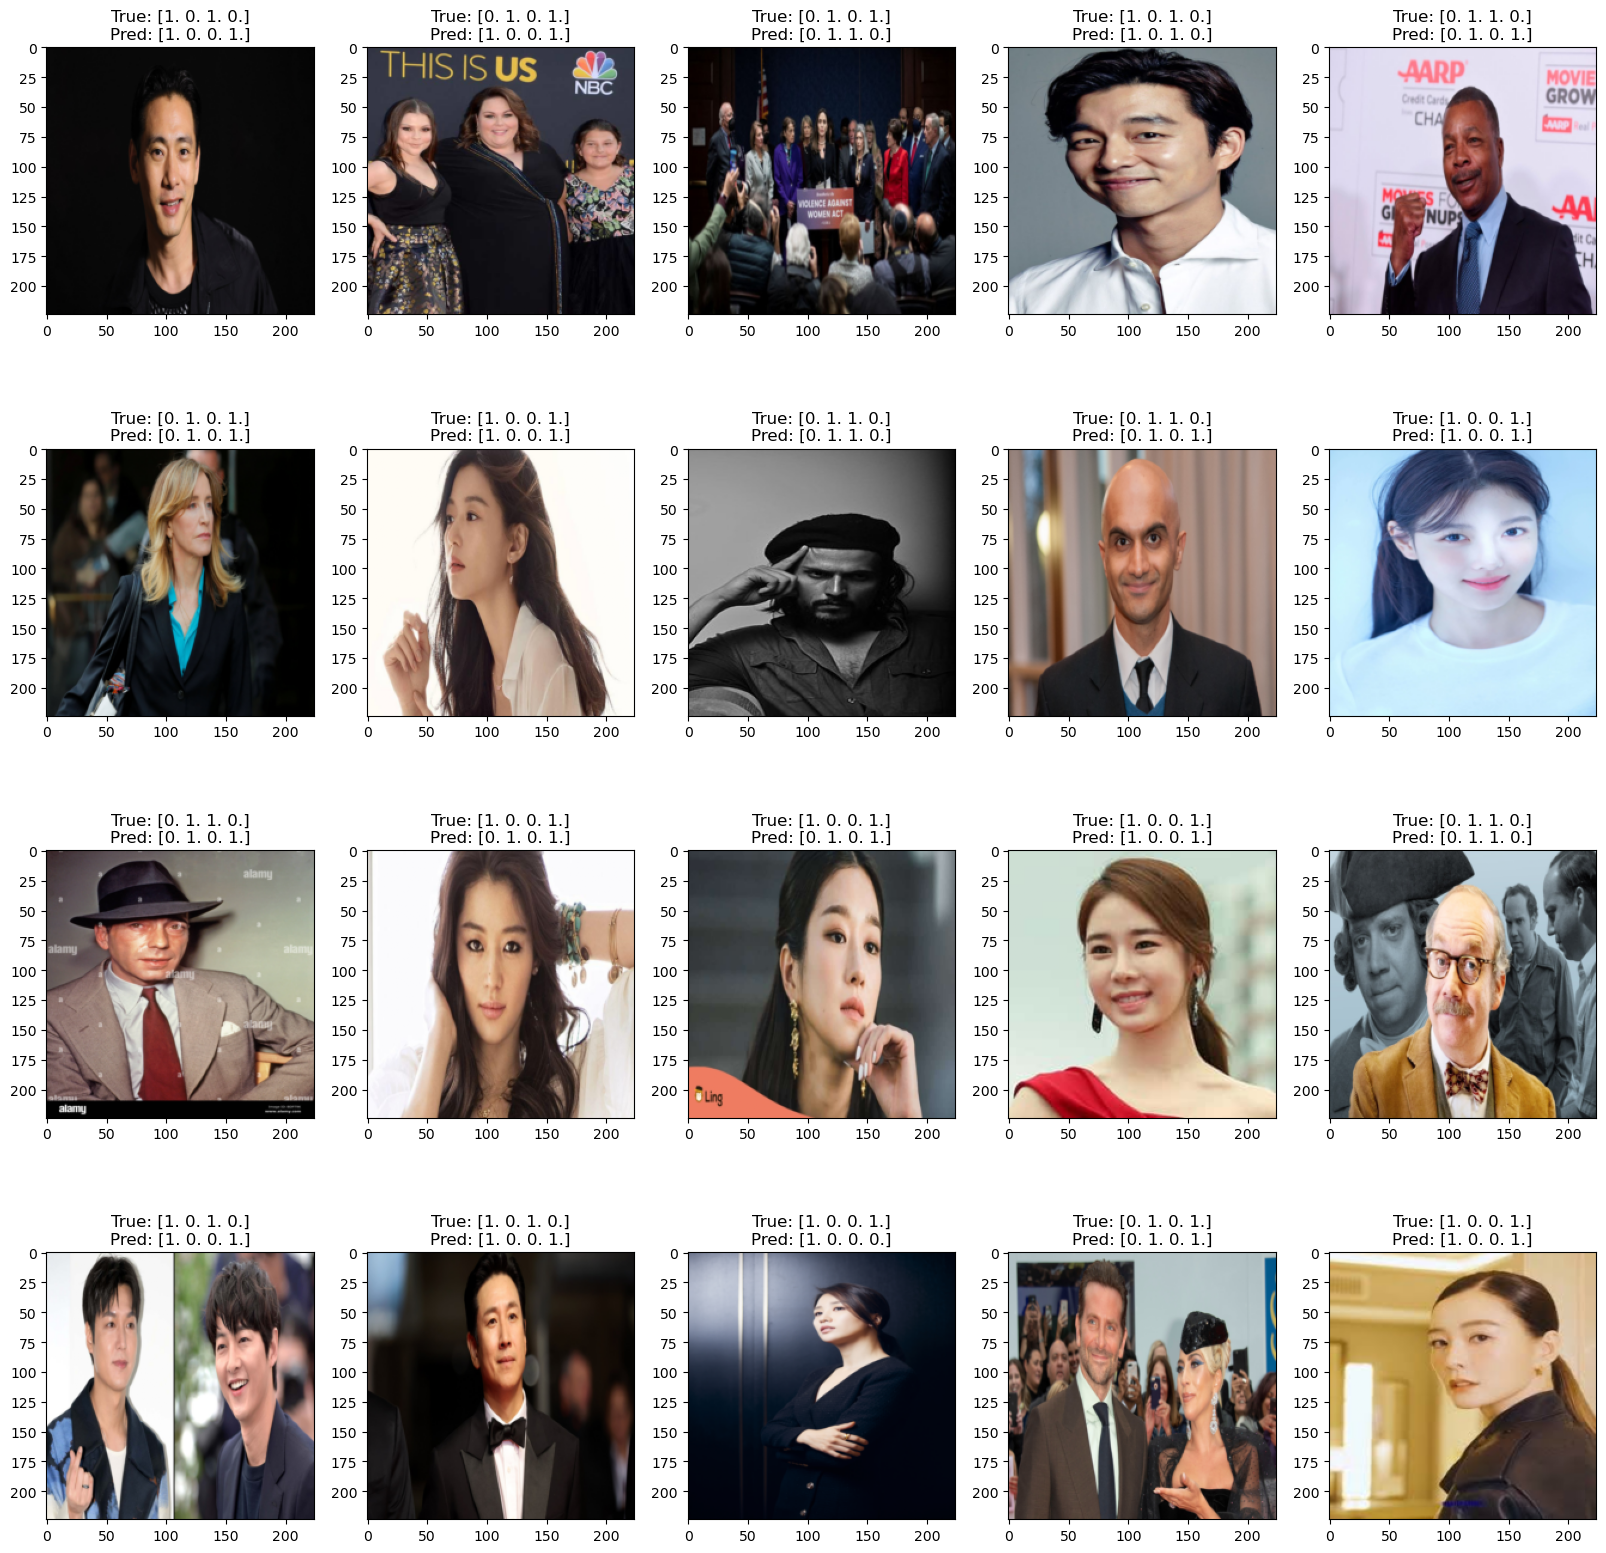

In [16]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')

# Grad Cam

In [17]:
class GradCam(torch.nn.Module):
    def __init__(self, model, module, layer=None):
        super().__init__()
        self.model = model # 학습한 모델
        self.module = module # 모델 내부의 특정 모듈
        self.layer = layer # 모듈 내부의 특정 layer
        self.register_hooks()

    def register_hooks(self):
        for module_name, module in self.model._modules.items():
            if module_name == self.module:
                for layer_name, module in module._modules.items():
                    if layer_name == self.layer:
                        if len(module._modules.items()) != 0:
                            list(module._modules.items())[-1][1].register_forward_hook(self.forward_hook)
                            list(module._modules.items())[-1][1].register_backward_hook(self.backward_hook)
                            print(f'Target Layer is {module_name}-{layer_name}, {list(module._modules.items())[-1][1]}')

                        else :
                            module.register_forward_hook(self.forward_hook)
                            module.register_backward_hook(self.backward_hook)
                            print(f'Target Layer is {module_name}-{layer_name}')

    def forward(self, input, target_class):
        outs = self.model(input)
        outs = outs.squeeze()

        if target_class is None:
            target_class = outs.argmax()

        outs[target_class].backward(retain_graph=True)

        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)

        importance_weights = torch.sum(a_k + self.forward_result, dim=0)

        activation_map = torch.relu(importance_weights)/torch.max(importance_weights)
        
        return activation_map, outs, outs.argmax()
    
    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(torch.tensor(output))

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(torch.tensor(grad_output[0]))

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

torch.Size([1, 3, 224, 224])


/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


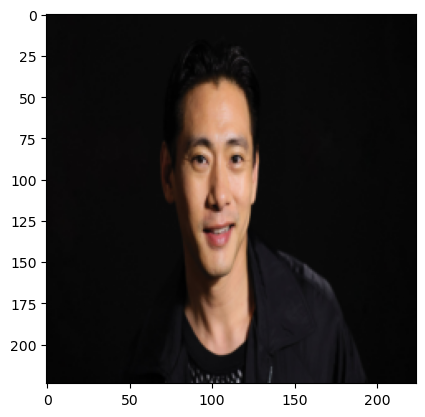

In [19]:
img = test_dataset[0][0].unsqueeze(0).to(device)
print(img.shape)
plt.imshow(img.cpu().squeeze().permute(1, 2, 0))

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [21]:
model.layer4[1]._modules.items()

odict_items([('conv1', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)), ('bn1', BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('drop_block', Identity()), ('act1', ReLU(inplace=True)), ('aa', Identity()), ('conv2', Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)), ('bn2', BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('act2', ReLU(inplace=True))])

Target Layer is layer4-1, ReLU(inplace=True)


/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2203866789.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.forward_result = torch.squeeze(torch.tensor(output))
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_59515/2203866789.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

torch.Size([7, 7]) 3


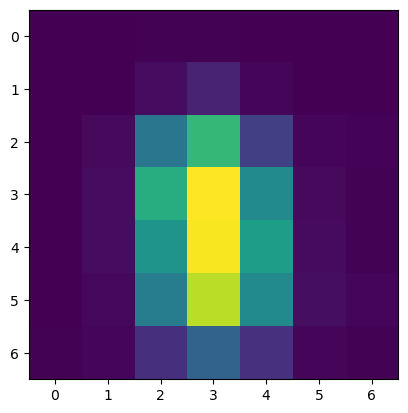

In [22]:
grad_cam = GradCam(model=model, module='layer4', layer='1')
mask, outs, cls_pred = grad_cam(img, None)

print(mask.shape, cls_pred.item())
plt.imshow(mask.cpu().detach().squeeze().numpy())

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_18124/2227902721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  classes = torch.tensor(self.data_df.iloc[idx, 1:]).to(torch.float) # self.data_df.iloc[idx, 1:]으로 하면 series형태라 오류 발생


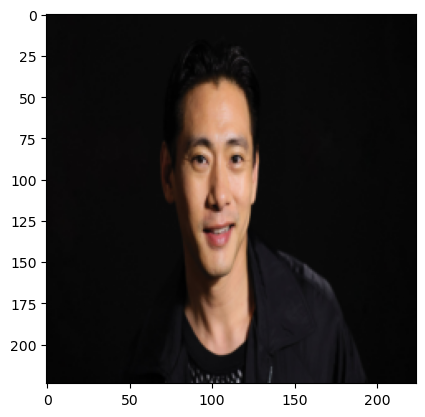

In [23]:
im = test_dataset[0][0].permute(1, 2, 0)
plt.imshow(im)

In [23]:
def mask_show(img, mask):
    img = img.squeeze().permute(1, 2, 0)
    mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), [224, 224], mode='bilinear')
    mask = mask.cpu().detach().squeeze().numpy()
    
    plt.imshow(img.cpu())
    plt.imshow(mask, cmap='jet', alpha=0.5)

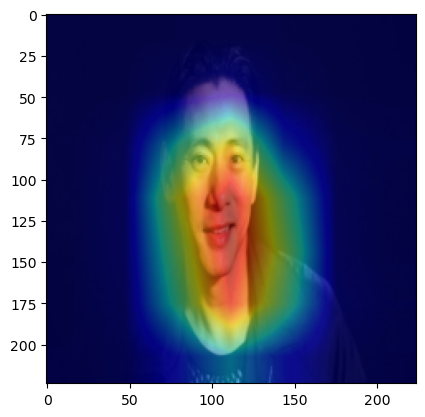

In [24]:
mask_show(img, mask)